Im diesen Notebook wird zunächst die exploratorische Datenanalyse und der Durchlauf des Dienstes grob dargestellt.

# EDA – Rohdaten (P_MW + Wetter)


In [9]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from src import config as cfg

RAW_DIR = Path(cfg.RAW_TS_DIR)
FREQ = getattr(cfg, "FREQ", "15min")
TZ = getattr(cfg, "TIMEZONE", "Europe/Berlin")

def read_raw(node_id: str) -> pd.DataFrame:
    p = RAW_DIR / f"{node_id}_hist.csv"
    df = pd.read_csv(p, parse_dates=["timestamp"])
    df["timestamp"] = pd.to_datetime(df["timestamp"], utc=True, errors="coerce")
    df = df.dropna(subset=["timestamp"]).sort_values("timestamp")
    df = df.set_index("timestamp")
    return df

def local_index(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()
    out.index = out.index.tz_convert(TZ).tz_localize(None)
    return out

print("FREQ:", FREQ)


FREQ: 15min


Für die Auswertung werden die Rohdaten direkt aus dem Pipeline-Output geladen.

Zeitstempel liegen intern in UTC vor und werden für die Visualisierung in die lokale Zeit (Europe/Berlin) überführt.

Die weitere Analyse basiert auf einer 15-minütigen zeitlichen Auflösung.

## Überblick über verfügbare Zeitreihen

In [10]:
files = sorted(RAW_DIR.glob("*_hist.csv"))
node_ids = [p.stem.replace("_hist", "") for p in files]

print("n_files:", len(files))
print("first 10 node_ids:", node_ids[:10])


n_files: 16
first 10 node_ids: ['BOLN_E01', 'BOLN_E02', 'BOLN_E03', 'BOLS_E41', 'BOLS_E42', 'JUBO_E01', 'JUBO_E02', 'JUBO_E03', 'SHUW_E23', 'SHUW_E24']


Im nächsten Schritt wird geprüft, welche Rohdaten tatsächlich vorliegen.

Insgesamt stehen aktuell 16 Knoten mit historischen Zeitreihen zur Verfügung, die als Grundlage für die weitere Analyse dienen.

## Exemplarischer Knoten

In [11]:
node_id = node_ids[9]
node_id

'SHUW_E24'

Für die folgenden Visualisierungen wird der Knoten SHUW_E24 exemplarisch ausgewählt, um Aufbau, zeitliche Struktur und typische Eigenschaften einer Rohzeitreihe zu veranschaulichen.

## Struktur der Rohdaten

In [12]:
df = read_raw(node_id)
display(df.head(5))


,P_MW,temperature_C,wind_speed_mps,solar_radiation_Wm2
timestamp,,,,
2024-01-01 00:00:00+00:00,-22.996800,6.7,16.7,0.0
2024-01-01 00:15:00+00:00,-23.516007,6.7,16.7,0.0
2024-01-01 00:30:00+00:00,-23.192500,6.7,16.3,0.0
2024-01-01 00:45:00+00:00,-22.885967,6.6,16.3,0.0
2024-01-01 01:00:00+00:00,-24.715713,6.6,17.7,0.0


Die Rohzeitreihe liegt im 15-Minuten-Raster vor und enthält neben der Wirkleistung (P_MW) die zugehörigen Wettergrößen. Zeitstempel sind konsistent in UTC gespeichert, was eine saubere Weiterverarbeitung ermöglicht.

## Umfang und Zeitraum

In [13]:
print("shape:", df.shape)
print("cols:", list(df.columns))
print("index tz:", df.index.tz)
print("time range (UTC):", df.index.min(), "->", df.index.max())

shape: (72066, 4)
cols: ['P_MW', 'temperature_C', 'wind_speed_mps', 'solar_radiation_Wm2']
index tz: UTC
time range (UTC): 2024-01-01 00:00:00+00:00 -> 2026-01-20 16:15:00+00:00


Die Zeitreihe umfasst rund 72 000 Messpunkte im 15-Minuten-Raster und deckt einen durchgehenden Zeitraum von Anfang 2024 bis Anfang 2026 ab. Alle Zeitstempel sind einheitlich in UTC geführt.

## Datenvollständigkeit

In [14]:
s = df["P_MW"] if "P_MW" in df.columns else None
if s is None:
    raise ValueError("Spalte P_MW fehlt in dieser Datei.")

s = s.sort_index()
full_idx = pd.date_range(s.index.min(), s.index.max(), freq=FREQ, tz="UTC")
s_full = s.reindex(full_idx)

n_total = len(s_full)
n_nan = int(s_full.isna().sum())
cov = 100.0 * (1 - n_nan / n_total) if n_total else 0.0

# längster NaN-Block
isna = s_full.isna()
grp = (isna != isna.shift()).cumsum()
block_sizes = isna.groupby(grp).sum()
max_nan_block = int(block_sizes[block_sizes > 0].max()) if (isna.any()) else 0

print(f"coverage: {cov:.2f}% | n_total={n_total} | n_nan={n_nan} | max_nan_block_steps={max_nan_block}")


coverage: 96.33% | n_total=72066 | n_nan=2646 | max_nan_block_steps=1591


Die Wirkleistungszeitreihe weist eine Abdeckung von rund 97 % auf. Fehlende Werte treten überwiegend in zusammenhängenden Blöcken auf, was auf systematische Ausfälle (z. B. Mess- oder Übertragungsprobleme) und nicht auf vereinzeltes Rauschen hindeutet.

## Zeitlicher Verlauf der Wirkleistung

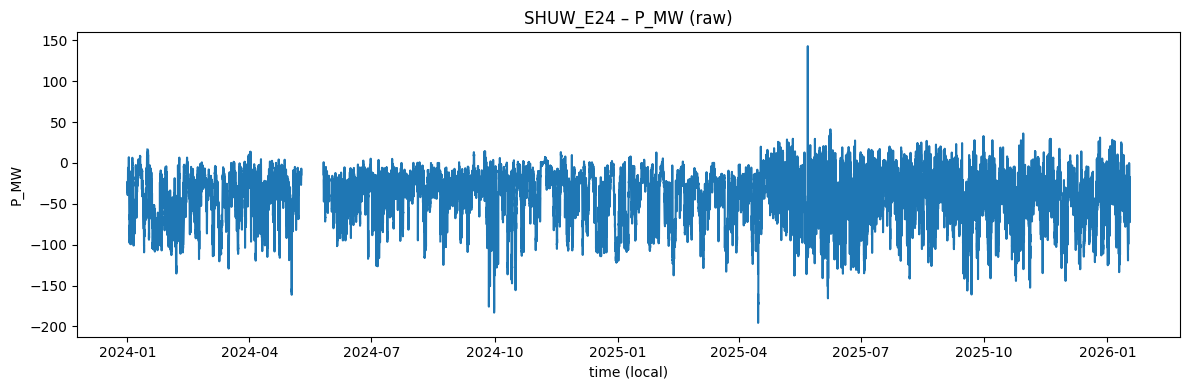

In [15]:
dfp = local_index(df)

plt.figure(figsize=(12,4))
plt.plot(dfp.index, dfp["P_MW"])
plt.title(f"{node_id} – P_MW (raw)")
plt.xlabel("time (local)")
plt.ylabel("P_MW")
plt.tight_layout()
plt.show()


Die Rohzeitreihe zeigt eine deutlich schwankende Einspeise- bzw. Bezugsleistung mit einzelnen Ausreißern und längeren Phasen erhöhter Varianz. Strukturelle Muster (z. B. Tages- oder Saisonalität) sind erkennbar, die Daten sind jedoch klar unbehandelt und enthalten auch Extremwerte.

## Wetterzeitreihen

weather cols detected: ['temperature_C', 'wind_speed_mps', 'solar_radiation_Wm2']


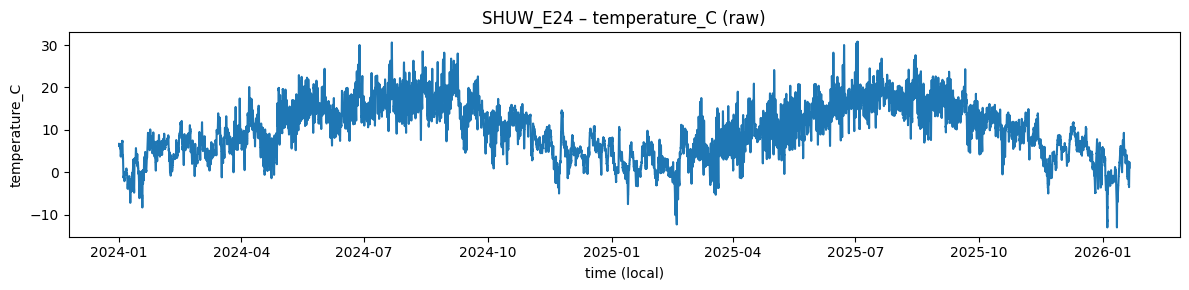

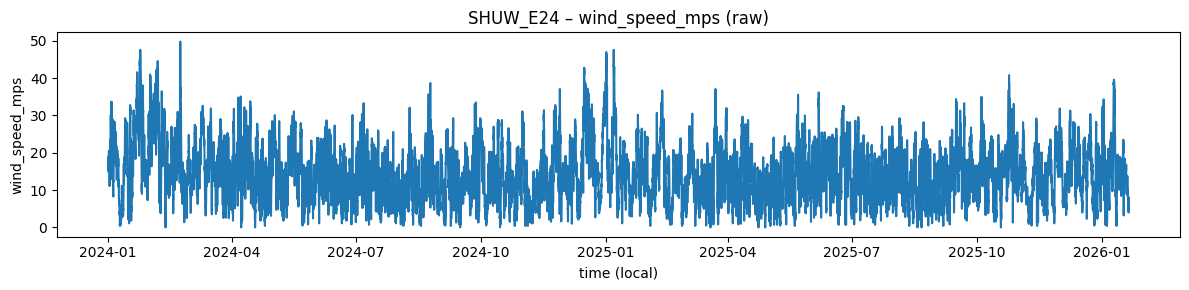

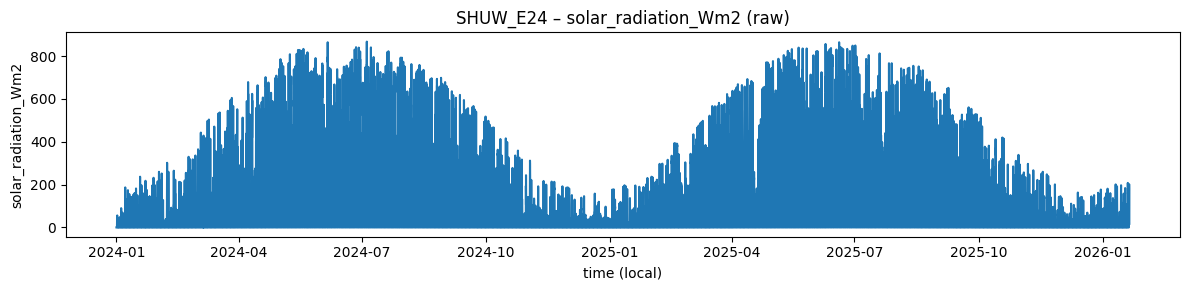

In [16]:
dfp = local_index(df)

weather_cols = [c for c in dfp.columns if c.lower().startswith(("wind", "temp", "solar", "global", "radiation"))]
print("weather cols detected:", weather_cols)

for c in weather_cols:
    plt.figure(figsize=(12,3))
    plt.plot(dfp.index, dfp[c])
    plt.title(f"{node_id} – {c} (raw)")
    plt.xlabel("time (local)")
    plt.ylabel(c)
    plt.tight_layout()
    plt.show()


Temperatur, Windgeschwindigkeit und solare Einstrahlung zeigen die erwarteten zeitlichen Muster. Die Temperatur und die solare Einstrahlung sind klar saisonal geprägt, während die Windgeschwindigkeit stärker kurzfristig schwankt. Auffällige Unstetigkeiten oder offensichtliche Artefakte sind nicht erkennbar, sodass die Wetterdaten als konsistente exogene Einflussgrößen genutzt werden können.

## Verteilung der Wirkleistung

quantiles [1%,5%,50%,95%,99%]: [-118.97047133  -97.572805    -33.08926667   -2.04639057    8.3241559 ]


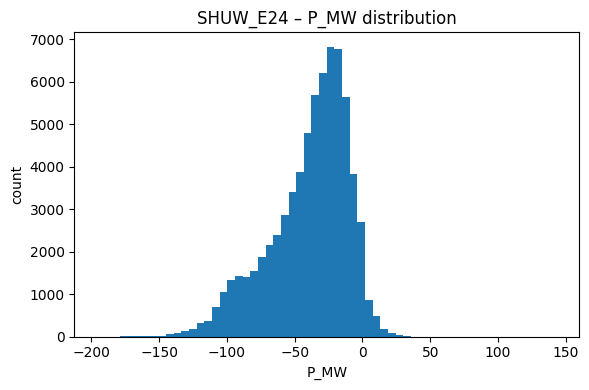

In [17]:
x = df["P_MW"].astype(float).dropna().to_numpy()
q = np.quantile(x, [0.01, 0.05, 0.5, 0.95, 0.99]) if len(x) else None
print("quantiles [1%,5%,50%,95%,99%]:", q)

plt.figure(figsize=(6,4))
plt.hist(x, bins=60)
plt.title(f"{node_id} – P_MW distribution")
plt.xlabel("P_MW")
plt.ylabel("count")
plt.tight_layout()
plt.show()


Die Verteilung der Wirkleistung ist deutlich asymmetrisch und wird von negativen Werten dominiert. Extreme Ausreißer treten nur selten auf, der Großteil der Werte liegt in einem vergleichsweise engen Bereich, was für die Modellierung gut handhabbar ist.

## Tagesprofil der Wirkleistung

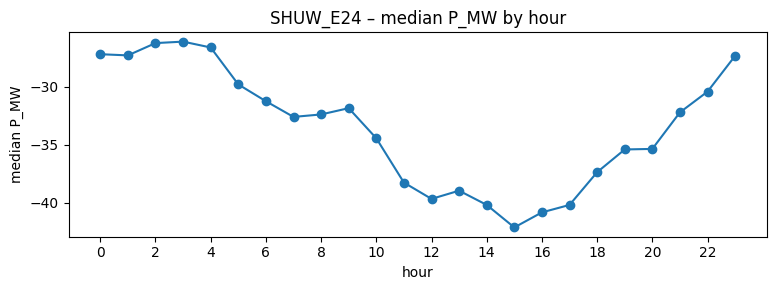

In [18]:
dfp = local_index(df)
tmp = dfp[["P_MW"]].dropna().copy()
tmp["hour"] = tmp.index.hour

profile = tmp.groupby("hour")["P_MW"].median()

plt.figure(figsize=(8,3))
plt.plot(profile.index, profile.values, marker="o")
plt.title(f"{node_id} – median P_MW by hour")
plt.xlabel("hour")
plt.ylabel("median P_MW")
plt.xticks(range(0,24,2))
plt.tight_layout()
plt.show()


Das stündliche Median-Profil zeigt einen klaren Tagesgang mit höheren Einspeise- bzw. geringeren Bezugswerten in den Nachtstunden und einem ausgeprägten Minimum zur Mittagszeit. Dieses Muster deutet auf systematische tageszeitliche Effekte hin, die für die Prognose relevant sind.

## Zusammenhang mit Wettergrößen

In [19]:
dfc = df.copy()
cols = ["P_MW"] + [c for c in dfc.columns if c != "P_MW"]
dfc = dfc[cols].apply(pd.to_numeric, errors="coerce")

# nur wenn sinnvolle wetterspalten existieren
cand = [c for c in dfc.columns if c != "P_MW"]
if not cand:
    print("keine weiteren Spalten für Korrelation")
else:
    corrs = dfc[["P_MW"] + cand].corr(numeric_only=True)["P_MW"].drop("P_MW").sort_values(key=lambda s: s.abs(), ascending=False)
    display(corrs.to_frame("corr_with_P_MW"))


,corr_with_P_MW
wind_speed_mps,-0.775222
solar_radiation_Wm2,-0.137409
temperature_C,-0.051178


Die Korrelationen zeigen einen deutlichen Zusammenhang zwischen Wirkleistung und Windgeschwindigkeit, während Temperatur und solare Einstrahlung nur eine untergeordnete Rolle spielen. Damit bestätigt sich Wind als zentraler exogener Treiber für diesen Knoten.

## Datenabdeckung über alle Knoten

In [20]:
rows = []
for nid in node_ids:
    try:
        dfi = read_raw(nid)
        if "P_MW" not in dfi.columns:
            continue
        s = dfi["P_MW"].sort_index()
        full_idx = pd.date_range(s.index.min(), s.index.max(), freq=FREQ, tz="UTC")
        s_full = s.reindex(full_idx)
        n_total = len(s_full)
        n_nan = int(s_full.isna().sum())
        cov = 100.0 * (1 - n_nan / n_total) if n_total else 0.0

        rows.append({
            "node_id": nid,
            "start_utc": s.index.min(),
            "end_utc": s.index.max(),
            "n_points_raw": int(len(s)),
            "coverage_pct": round(cov, 3),
            "n_missing_steps": n_nan,
        })
    except Exception as e:
        rows.append({"node_id": nid, "error": str(e)})

overview = pd.DataFrame(rows)
display(overview.sort_values(["coverage_pct", "n_points_raw"], ascending=[True, True]).head(20))
print("nodes ok:", int(overview["node_id"].notna().sum()))


,node_id,start_utc,end_utc,n_points_raw,coverage_pct,n_missing_steps
15,WEDING_E14,2024-01-01 00:00:00+00:00,2026-01-20 16:15:00+00:00,72066,26.408,53035
14,WEDING_E12,2024-01-01 00:00:00+00:00,2026-01-20 16:15:00+00:00,72066,26.409,53034
3,BOLS_E41,2024-01-01 00:00:00+00:00,2026-01-20 16:15:00+00:00,72066,26.438,53013
4,BOLS_E42,2024-01-01 00:00:00+00:00,2026-01-20 16:15:00+00:00,72066,26.441,53011
11,SIEV_E01,2024-01-01 00:00:00+00:00,2026-01-20 16:15:00+00:00,72066,93.521,4669
8,SHUW_E23,2024-01-01 00:00:00+00:00,2026-01-20 16:15:00+00:00,72066,93.810,4461
10,SIES_E02,2024-01-01 00:00:00+00:00,2026-01-20 16:15:00+00:00,72066,96.192,2744
2,BOLN_E03,2024-01-01 00:00:00+00:00,2026-01-20 16:15:00+00:00,72066,96.326,2648
9,SHUW_E24,2024-01-01 00:00:00+00:00,2026-01-20 16:15:00+00:00,72066,96.328,2646
0,BOLN_E01,2024-01-01 00:00:00+00:00,2026-01-20 16:15:00+00:00,72066,96.345,2634


nodes ok: 16


Die meisten nodes haben eine hohe Abdeckung verfügbarer Daten. Die Knoten in WEDING_XX und BOLS_XX haben allerdings eine geringe Abdeckung mit ca. 26%.

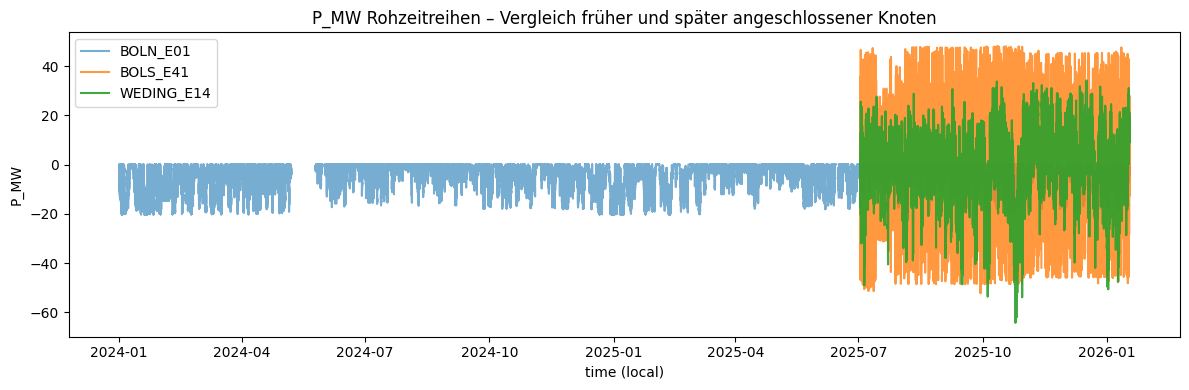

In [21]:
ref_node = "BOLN_E01"     
late_node = "WEDING_E14"  
bols_node = "BOLS_E41"    

df_ref = read_raw(ref_node)
df_late = read_raw(late_node)
df_bols = read_raw(bols_node)

plt.figure(figsize=(12,4))
plt.plot(local_index(df_ref).index, df_ref["P_MW"], label=ref_node, alpha=0.6)
plt.plot(local_index(df_bols).index, df_bols["P_MW"], label=bols_node, alpha=0.8)
plt.plot(local_index(df_late).index, df_late["P_MW"], label=late_node, alpha=0.9)

plt.title("P_MW Rohzeitreihen – Vergleich früher und später angeschlossener Knoten")
plt.xlabel("time (local)")
plt.ylabel("P_MW")
plt.legend()
plt.tight_layout()
plt.show()



Die Zeitreihen verdeutlichen, dass die geringe Datenabdeckung einzelner Knoten (z. B. WEDING, BOLS) nicht auf Datenverlust, sondern auf spätere Inbetriebnahme zurückzuführen ist. Alle Knoten teilen eine gemeinsame Zeitachse, Messwerte liegen jedoch erst ab dem jeweiligen Anschlusszeitpunkt vor.

# Demonstration des Dienstes

In [22]:
raw_files = sorted(Path(cfg.RAW_TS_DIR).glob("*_hist.csv"))
wf_files = sorted(Path(cfg.WEATHER_FORECAST_DIR).glob("*_weather_forecast.csv"))

print("raw *_hist.csv:", len(raw_files))
print("weather_forecast *_weather_forecast.csv:", len(wf_files))
print("example raw:", raw_files[0].name if raw_files else None)
print("example wf :", wf_files[0].name if wf_files else None)


raw *_hist.csv: 16
weather_forecast *_weather_forecast.csv: 16
example raw: BOLN_E01_hist.csv
example wf : BOLN_E01_weather_forecast.csv


## STEP 1: In-memory Cleaning (Interpolation + Coverage Report)

In [ ]:
from pathlib import Path
import pandas as pd
import src.config as cfg

TS_COL = "timestamp"
DATA_DIR = Path(cfg.PREP_TS_DIR)

files = sorted(DATA_DIR.glob("*_hist*.csv"))
if not files:
    raise RuntimeError(f"Keine CSVs in {DATA_DIR.resolve()} gefunden")

print(f"Found {len(files)} CSV files")

data = {}
for p in files:
    node_id = (
        p.stem
        .replace("_hist_clean", "")
        .replace("_hist", "")
    )

    df = pd.read_csv(p)
    if TS_COL not in df.columns:
        print(f"Skip {p.name}: no timestamp column")
        continue

    df[TS_COL] = pd.to_datetime(df[TS_COL], errors="coerce", utc=True)
    df = df.dropna(subset=[TS_COL]).sort_values(TS_COL)

    data[node_id] = df

print(f"Loaded nodes: {len(data)}")

node = next(iter(data))
df = data[node]

print("Node:", node)
print("Rows:", len(df))
print("Columns:", list(df.columns))
print("Time range:", df["timestamp"].min(), "->", df["timestamp"].max())

display(df.head())


Found 16 CSV files
Loaded nodes: 16
Node: BOLN_E01
Rows: 72066
Columns: ['timestamp', 'P_MW', 'temperature_C', 'wind_speed_mps', 'solar_radiation_Wm2']
Time range: 2024-01-01 00:00:00+00:00 -> 2026-01-20 16:15:00+00:00


,timestamp,P_MW,temperature_C,wind_speed_mps,solar_radiation_Wm2
0,2024-01-01 00:00:00+00:00,-8.337319,6.7,18.8,0.0
1,2024-01-01 00:15:00+00:00,-8.349231,6.7,18.4,0.0
2,2024-01-01 00:30:00+00:00,-7.637581,6.7,18.1,0.0
3,2024-01-01 00:45:00+00:00,-6.497155,6.6,17.5,0.0
4,2024-01-01 01:00:00+00:00,-6.765141,6.5,17.9,0.0


Die Rohdaten werden geladen und anschließend in einer ersten Bereinigungsstufe konsolidiert.

Der Wetter-Forecast wird in diesem Schritt bewusst nicht neu erzeugt, da er für die nachfolgende Analyse und die Demonstration der Pipeline nicht erforderlich ist.

Das Ergebnis ist ein konsistentes In-Memory-Datenbündel mit Knotenmetadaten, Wirkleistungszeitreihen und historischen Wetterdaten für alle betrachteten Netzpunkte.

## STEP 2: BESS-Einfluss entfernen (Ridge) -> schreibt *_hist_clean.csv nach CLEAN_TS_DIR

In [ ]:
from src.network.bess_cleaning import clean_all_nodes_remove_bess_from_graph

clean_series, report_df = clean_all_nodes_remove_bess_from_graph(
    graph_path=Path(cfg.GRAPH_PATH),
    raw_ts_dir=Path(cfg.RAW_TS_DIR),
    ts_col="timestamp",
    val_col="P_MW",
    min_overlap_points=200,
    out_dir=None,  # -> cfg.CLEAN_TS_DIR
    include_intercept_in_removal=False,
    ridge_alpha=1.0,
    write_report_csv=True,
)

print("written series:", len(clean_series))
display(report_df.head(10))


written series: 14


,node_id,n_fit,r2,corr_y_removed,beta_abs_sum,ridge_alpha,beta__BOLS_E41_hist.csv,beta__BOLS_E42_hist.csv
0,WEDING_E12,18996,0.199331,0.445896,0.292154,1.0,-0.269680,-0.022473
1,WEDING_E14,18995,0.097937,0.312470,0.228663,1.0,-0.007148,-0.221515
2,SHUW_E23,19046,0.227895,0.282302,0.759400,1.0,-0.657869,0.101532
3,TARP_E01,19035,0.180972,0.234170,0.362802,1.0,-0.052733,-0.310069
4,SHUW_E24,19045,0.104586,0.168963,0.701223,1.0,0.096109,-0.605114
5,TARP_E03,19028,0.096407,0.137357,0.221212,1.0,0.010084,0.211128
6,SIEV_E01,19017,0.055946,0.121428,0.158196,1.0,0.052706,0.105490
7,JUBO_E03,19034,0.042517,0.095444,0.068945,1.0,0.023363,0.045582
8,JUBO_E01,19053,0.016415,0.060612,0.115553,1.0,-0.041679,-0.073874
9,JUBO_E02,19032,0.004250,0.031195,0.046862,1.0,0.017708,0.029154


In diesem Schritt wird der Einfluss der Batteriespeicher aus den Wirkleistungszeitreihen entfernt.

Dazu wird für jeden Knoten eine multivariate Ridge-Regression auf Basis der im Netzgraphen verknüpften Batteriesignale durchgeführt.

Neben den bereinigten Zeitreihen werden Qualitätskennzahlen der Anpassung (u. a. Korrelation und Regressionskoeffizienten) zur Nachvollziehbarkeit protokolliert.

## STEP 4: Powerbands -> schreibt pro battery eine CSV nach POWERBAND_DIR

In [ ]:
import src.battery_bands as bb

bb.run()

out_files = sorted(Path(cfg.POWERBAND_DIR).glob("*_powerband.csv"))
print("powerband files:", len(out_files))
print("example:", out_files[0].name if out_files else None)


Config: UTIL_TARGET_PCT=50.0% (scale=0.500)


powerband files: 2
example: BOLS_E41_powerband.csv


Abschließend werden auf Basis der prognostizierten Netzlasten und der PTDF-basierten Netzsensitivitäten zeitabhängige Leistungsbänder für die Batteriespeicher berechnet.

Das Ergebnis sind CSV-Dateien mit zulässigen Einspeise- und Bezugsgrenzen je Batteriespeicher und Zeitschritt.

## Eine Leistungsband-Datei laden

In [ ]:
if out_files:
    pb = pd.read_csv(out_files[0], parse_dates=["timestamp"])
    display(pb.head(10))
    print("rows:", len(pb), "range:", pb["timestamp"].min(), "->", pb["timestamp"].max())


,timestamp,P_min_MW,P_max_MW,reason
0,2026-01-18 21:15:00,-33.587439,50.0,NaN
1,2026-01-18 21:30:00,-37.968417,50.0,NaN
2,2026-01-18 21:45:00,-41.654302,50.0,NaN
3,2026-01-18 22:00:00,-42.163171,50.0,NaN
4,2026-01-18 22:15:00,-41.011824,50.0,NaN
5,2026-01-18 22:30:00,-39.728987,50.0,NaN
6,2026-01-18 22:45:00,-36.490827,50.0,NaN
7,2026-01-18 23:00:00,-34.581319,50.0,NaN
8,2026-01-18 23:15:00,-33.301657,50.0,NaN
9,2026-01-18 23:30:00,-35.205422,50.0,NaN


rows: 100 range: 2026-01-18 21:15:00 -> 2026-01-19 22:00:00


Die erzeugten Leistungsbänder enthalten für jeden Zeitschritt die zulässige minimale und maximale Wirkleistung des Batteriespeichers.

Die Zeitachse entspricht dem Prognosehorizont, die Grenzen ergeben sich aus den netzseitigen Restriktionen des betrachteten Szenarios.